In [1]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
import torch.nn as nn
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
import torch
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
from util.node import Node
import shutil
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
import pickle
from util.func import get_patch_size
import random
from util.data import ModifiedLabelLoader
from tqdm import tqdm

Heatmaps showing where a prototype is found will not be generated because OpenCV is not installed.


In [2]:
# run_path = '/home/harishbabu/projects/PIPNet/runs/010-CUB-27-imgnet_OOD_cnext26_img=224_nprotos=20'
# run_path = '/home/harishbabu/projects/PIPNet/runs/031-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/032-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
run_path = '/home/harishbabu/projects/PIPNet/runs/035-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

------------------------- No discretization -------------------------


In [3]:
print(root)

root
	052+053
		cub_052_Pied_billed_Grebe
		053+050
			cub_053_Western_Grebe
			050+051
				cub_050_Eared_Grebe
				cub_051_Horned_Grebe
	004+086
		004+032
			cub_004_Groove_billed_Ani
			032+033
				cub_032_Mangrove_Cuckoo
				033+031
					cub_033_Yellow_billed_Cuckoo
					cub_031_Black_billed_Cuckoo
		086+045
			cub_086_Pacific_Loon
			045+101
				045+003
					cub_045_Northern_Fulmar
					003+002
						cub_003_Sooty_Albatross
						002+001
							cub_002_Laysan_Albatross
							cub_001_Black_footed_Albatross
				101+023
					101+100
						cub_101_White_Pelican
						cub_100_Brown_Pelican
					023+025
						cub_023_Brandt_Cormorant
						025+024
							cub_025_Pelagic_Cormorant
							cub_024_Red_faced_Cormorant



In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

ckpt_path = os.path.join(run_path, 'checkpoints', 'net_trained_last')
checkpoint = torch.load(ckpt_path, map_location=device)

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)
if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)
net.eval()
criterion = nn.NLLLoss(reduction='mean').to(device)

# Forward one batch through the backbone to get the latent output size
# with torch.no_grad():
#     xs1, _, _ = next(iter(trainloader))
#     xs1 = xs1.to(device)
#     proto_features, _, _ = net(xs1)
#     wshape = proto_features['root'].shape[-1]
#     args.wshape = wshape #needed for calculating image patch size
#     print("Output shape: ", proto_features['root'].shape, flush=True)
    
args.wshape = 26

Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}


/home/harishbabu/.conda/envs/hpnet1/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Number of prototypes:  20


Node 004+086


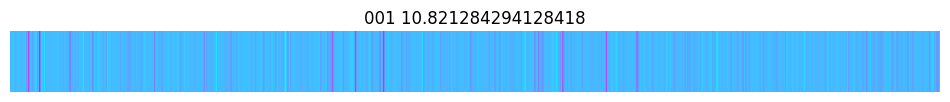

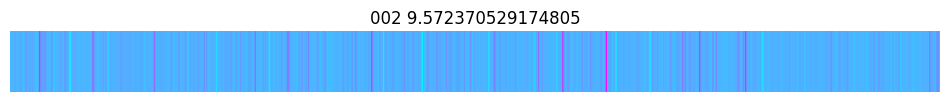

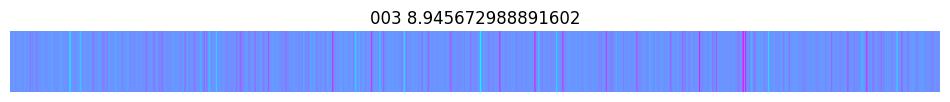

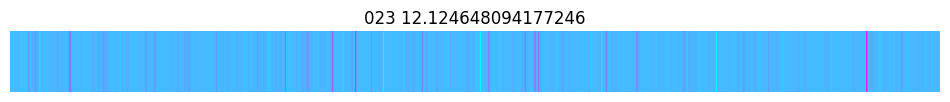

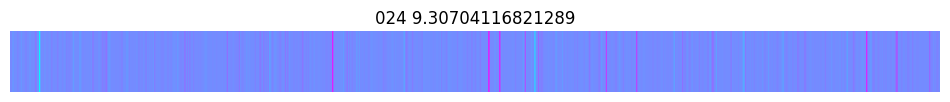

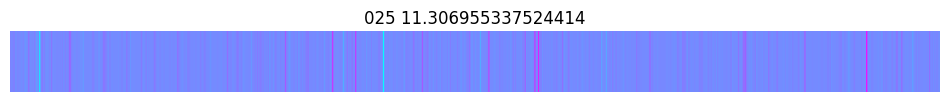

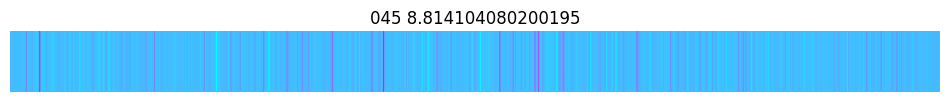

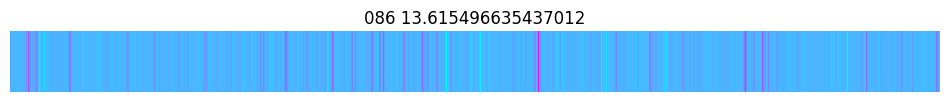

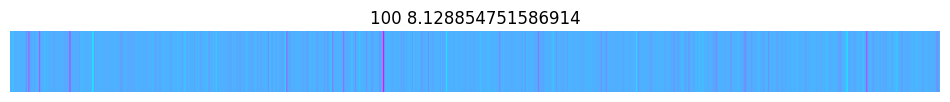

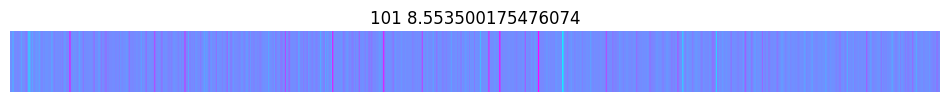

In [6]:
# Proto activations on leaf descendents - topk images

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import Image, ImageDraw as D
import torchvision
import matplotlib.pyplot as plt

topk = 10
save_images = False

def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)

# node = root.get_node('045+101')
# proto_idx = 1 #8

node = root.get_node('004+086')
proto_idx = 17 #8

non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]

name2label = projectloader.dataset.class_to_idx
label2name = {label:name for name, label in name2label.items()}
modifiedLabelLoader = ModifiedLabelLoader(projectloader, node)
coarse_label2name = modifiedLabelLoader.modifiedlabel2name
node_label_to_children = {label: name for name, label in node.children_to_labels.items()}

imgs = modifiedLabelLoader.filtered_imgs

img_iter = tqdm(enumerate(modifiedLabelLoader),
                total=len(modifiedLabelLoader),
                mininterval=50.,
                desc='Collecting topk',
                ncols=0)

classification_weights = getattr(net.module, '_'+node.name+'_classification').weight

# maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

# maps class names to the prototypes that belong to that
class_and_prototypes = defaultdict(set)

for i, (xs, orig_y, ys) in img_iter:
    if coarse_label2name[ys.item()] not in non_leaf_children_names:
        continue

    xs, ys = xs.to(device), ys.to(device)

    with torch.no_grad():
        softmaxes, pooled, _ = net(xs, inference=False)
        pooled = pooled[node.name].squeeze(0) 
        softmaxes = softmaxes[node.name]#.squeeze(0)

        for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
            c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
            relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
            relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]

            # Take the max per prototype.                             
            max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
            max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
            max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)

            h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
            w_idx = max_idx_per_prototype_w[p]

            if len(relevant_proto_class_names) == 0:
                continue

            if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
                continue

            h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)

            if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                child_node = root.get_node(coarse_label2name[ys.item()])
                leaf_descendent = label2name[orig_y.item()][4:7]
                img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                img_tensor = xs
                if topk and (len(proto_mean_activations[p][leaf_descendent]) > topk):
                    heapq.heappushpop(proto_mean_activations[p][leaf_descendent], (pooled[p].item(), img_to_open, img_tensor, (h_coor_min, h_coor_max, w_coor_min, w_coor_max)))
                else:
                    heapq.heappush(proto_mean_activations[p][leaf_descendent], (pooled[p].item(), img_to_open, img_tensor, (h_coor_min, h_coor_max, w_coor_min, w_coor_max)))

            class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)


print('Node', node.name)

contributions = []

for leaf_descendent in proto_mean_activations[proto_idx]:
    # [0] coz only taking the top most image from each descendent
    activation, img_to_open, img_tensor, (h_coor_min, h_coor_max, w_coor_min, w_coor_max) = proto_mean_activations[proto_idx][leaf_descendent][0] 
    
    features = net.module._net(img_tensor)
    
    proto_features = getattr(net.module, '_'+node.name+'_add_on')(features)
    softmaxes = net.module._softmax(proto_features)
    
    # Take the max per prototype.                             
    max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
    max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
    max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
    h_idx = max_idx_per_prototype_h[proto_idx, max_idx_per_prototype_w[proto_idx]]
    w_idx = max_idx_per_prototype_w[proto_idx]
    
    proto_vector = getattr(net.module, '_'+node.name+'_add_on').weight[proto_idx]
    feature_patch = features[:, :, h_idx, w_idx].squeeze()
    proto_vector = proto_vector.squeeze()
    # proto_vector_bias = getattr(net.module, '_'+node.name+'_add_on').bias[proto_idx]
    mul = torch.dot(feature_patch.squeeze(), proto_vector.squeeze()) # feature_patch @ proto_vector
    # proto_features[:, proto_idx, h_idx, w_idx]
    # print((mul+proto_vector_bias) == proto_features[:, proto_idx, h_idx, w_idx])
    contributions.append(feature_patch * proto_vector)
    
    # print(leaf_descendent)
    
    # Plot the tensor as an image
    # plot_tensor = (feature_patch * proto_vector).view(1, -1).repeat(100, 1).detach().cpu().numpy()
    c = (feature_patch * proto_vector)
    c = (c - c.min()) / (c.max() - c.min())
    plot_tensor = torch.repeat_interleave(c.view(1, -1).repeat(100, 1), 2, dim=1).detach().cpu().numpy() # .repeat(100, 1)
    fig = plt.figure(figsize=(12, 5))
    plt.imshow(plot_tensor, cmap='cool') # jet, hot, plasma
    plt.title(leaf_descendent + " " + str(mul.item()))
    plt.axis('off')  # Turn off the axis labels
    plt.show()
    
    
#     mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
#     num_images = len(proto_mean_activations[p][leaf_descendent])
#     logstr += f'{leaf_descendent}:({mean_activation}) '
# print(logstr)
            


In [ ]:
            if save_images:
                patches = []
                right_descriptions = []
                text_region_width = 7 # 7x the width of a patch
                for leaf_descendent, heap in proto_mean_activations[p].items():
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    for ele in heap:
                        activation, img_to_open, img_tensor, (h_coor_min, h_coor_max, w_coor_min, w_coor_max) = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        patches.append(img_tensor_patch)

                    # description on the right hand side
                    text = f'{mean_activation}, {leaf_descendent}'
                    txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (0, 0, 0))
                    draw = D.Draw(txtimage)
                    draw.text((5, patches[0].shape[1]//2), text, anchor='mm', fill="white")
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)

                grid = torchvision.utils.make_grid(patches, nrow=topk+1, padding=1)
                grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=1)

                # merging right description with the grid of images
                grid = torch.cat([grid, grid_right_descriptions], dim=-1)

                # description on the top
                text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                draw = D.Draw(txtimage)
                draw.text((5, patches[0].shape[1]//2), text, anchor='mm', fill="white")
                txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                grid = torch.cat([grid, txttensor], dim=1)

                os.makedirs(os.path.join(run_path, 'descendent_specific_topk', node.name), exist_ok=True)
                torchvision.utils.save_image(grid, os.path.join(run_path, 'descendent_specific_topk', node.name, f'{child_classname}-p{p}.png'))
            